## Import Packages Below:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Parameter Define Below:

In [2]:
canny_low_threshold = 50
canny_high_threshold = 150

hough_rho = 2 # distance resolution in pixels of the Hough grid
hough_theta = np.pi/180 # angular resolution in radians of the Hough grid
hough_threshold = 35    # minimum number of votes (intersections in Hough grid cell)
hough_min_line_len = 5 #minimum number of pixels making up a line
hough_max_line_gap = 2    # maximum gap in pixels between connectable line segments

r_line_slope_range = [0.4,0.8]
l_line_slope_range = [-0.8,-0.4]

## Function definition Below:

In [3]:
def grayscale(img):
    #convert the image to grayscale
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    #detect edges
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    #reduce image noise
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    #returns an image with hough lines drawn
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = draw_lines(line_img, lines)
    return line_img

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    
    r_slopes = []
    r_centers = []
    l_slopes = []
    l_centers = []
    
    y_bottom = img.shape[0]
    y_top = 330
    
    #sort the lines in to left line or right line group, those not in either group will be ignored
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = math.atan2((y2-y1),(x2-x1))
            center = [(x1+x2)/2,(y1+y2)/2]
            
            if slope>=r_line_slope_range[0] and slope<=r_line_slope_range[1]: #in range(r_line_slope_range[0],r_line_slope_range[1]):
                r_slopes.append(slope)
                r_centers.append(center)
            elif slope>=l_line_slope_range[0] and slope<=l_line_slope_range[1]: #in range(l_line_slope_range[0],l_line_slope_range[1]):
                l_slopes.append(slope)
                l_centers.append(center)    
    
    #draw right line
    if r_slopes != []:
        r_slope = np.sum(r_slopes)/len(r_slopes)
        r_center = np.divide(np.sum(r_centers,axis=0),len(r_slopes))
        r_x_bottom = int((y_bottom - r_center[1])/math.tan(r_slope) + r_center[0])
        r_x_top = int((y_top - r_center[1])/math.tan(r_slope) + r_center[0])
        r_line = [r_x_bottom, y_bottom, r_x_top, y_top]
        cv2.line(img, (r_line[0], r_line[1]), (r_line[2], r_line[3]), color, thickness)
    
    #draw left line
    if l_slopes != []:   
        l_slope = np.sum(l_slopes)/len(l_slopes)
        l_center = np.divide(np.sum(l_centers,axis=0),len(l_slopes))   
        l_x_bottom = int((y_bottom - l_center[1])/math.tan(l_slope) + l_center[0])
        l_x_top = int((y_top - l_center[1])/math.tan(l_slope) + l_center[0])
        l_line = [l_x_bottom, y_bottom, l_x_top, y_top]    
        cv2.line(img, (l_line[0], l_line[1]), (l_line[2], l_line[3]), color, thickness)
        
    #mark the parh between left and right lines
    mask = np.zeros_like(img)
    if (r_slopes != [] and l_slopes != []):
        path_color = (0,255,0)
        vertices = np.array([[(l_x_bottom, y_bottom),(l_x_top, y_top), (r_x_top, y_top), (r_x_bottom, y_bottom)]], dtype=np.int32)
        cv2.fillPoly(mask, vertices, path_color)
    
    # optional to mark the path between 2 lines
    result = weighted_img(mask,img, α=1.0, β=0.2) 
    
    #just draw lines
#    result = img 

    return result
            
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def RGB2BGR(img):
    #convert RGB sequence for cv2.imwrite
    r,g,b = cv2.split(img)
    return cv2.merge((b,g,r))

def process_image(image):
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 3)
    edges = canny(blur_gray, canny_low_threshold, canny_high_threshold)
    
    imshape = image.shape
    vertices = np.array([[(50,imshape[0]),(400, 320), (550, 320), (900,imshape[0])]], dtype=np.int32)
    target = region_of_interest(edges, vertices)
    lines = hough_lines(target, hough_rho, hough_theta, hough_threshold, hough_min_line_len, hough_max_line_gap)

    result = weighted_img(lines, image)
    return result

## Main part of finding lanes in image below:

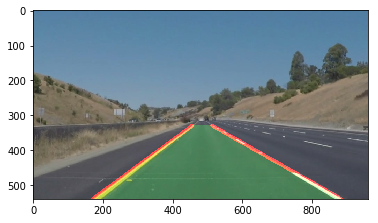

In [4]:
files = os.listdir('test_images/')
for file in files:
    img = plt.imread(file)

    result = process_image(img)
    plt.imshow(result, cmap = 'gray')

    cv2.imwrite('test_images/output_' + file, RGB2BGR(result))

## Main part of finding lanes in videos below:

In [5]:
files = os.listdir('test_videos/')
for file in files:
    file_output = 'test_videos/output_' + file

    clip1 = VideoFileClip(file)
    clip1 = clip1.resize(height=540)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(file_output, audio=False)

[MoviePy] >>>> Building video test_videos/output_challenge.mp4
[MoviePy] Writing video test_videos/output_challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:11<00:00, 25.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/output_challenge.mp4 

Wall time: 12.4 s
[MoviePy] >>>> Building video test_videos/output_solidWhiteRight.mp4
[MoviePy] Writing video test_videos/output_solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:05<00:00, 38.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/output_solidWhiteRight.mp4 

Wall time: 6.45 s
[MoviePy] >>>> Building video test_videos/output_solidYellowLeft.mp4
[MoviePy] Writing video test_videos/output_solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:18<00:00, 36.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/output_solidYellowLeft.mp4 

Wall time: 19.6 s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(file_output))